<a href="https://colab.research.google.com/github/bhomaidan1990/Computer_Vision_Labs/blob/main/CV_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Course
## Lab 3 Pyramids

In [1]:
##########################
# @Authors:              #
#     Belal Hmedan       #
# &   Junyi ZHONG        #
##########################
#
#========================
# Import Libraries
#========================
import os
import glob
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from keras.preprocessing import image
import cv2
import time
from math import sqrt, ceil, floor
import keras 
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
#--------------------------------------------
from skimage import exposure as exposure
# from scipy.ndimage import affine_transform

#### Reproducible Code Initialization

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

### Download the Dataset and related files

In [3]:
#=======================
# Download the dataset
#=======================
# !rm originalPics.tar.gz & rm FDDB-folds.tgz & rm test_db.zip
# !rm -rf Dataset & rm -rf FDDB-folds & rm -rf sample_data & rm -rf NewDataset
#
!wget http://tamaraberg.com/faceDataset/originalPics.tar.gz
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
# ================
# Wider DataSet
# ================
# !wget https://drive.google.com/u/0/uc?export=download&confirm=BkuU&id=0B6eKvaijfFUDbW4tdGpaYjgzZkU
# !wget https://drive.google.com/u/0/uc?export=download&confirm=aArG&id=0B6eKvaijfFUDd3dIRmpvSk8tLUk
# !wget https://drive.google.com/u/0/uc?export=download&confirm=GOPW&id=0B6eKvaijfFUDQUUwd21EckhUbWs
#-----------------------
# Test_Data
#==================
!wget http://crowley-coutaz.fr/jlc/Courses/2020/GVR.VO/test_db.zip
!unzip test_db.zip &> /dev/null
!mv TESTSET test
#-----------------------------------------------------------
# Extract the data
#==================
t0 = time.time()
!mkdir original && tar xvzf originalPics.tar.gz -C original &> /dev/null
!tar xvzf FDDB-folds.tgz &> /dev/null
!rm originalPics.tar.gz & rm FDDB-folds.tgz & rm test_db.zip & rm -rf sample_data
# # create the output dataset folder
# #-----------------------------------------------------------
# if (not os.path.isdir('Dataset')):
#     os.mkdir('Dataset')
# #-------------------------------------------------
# for im in glob.glob('/content/original/**/*.jpg', recursive=True):
#     # print(im)
#     shutil.copy(im, 'Dataset')
# #-------------------------------------------------
t1 = time.time()
print('DeCompressing Time is : ',t1-t0," seconds")

--2020-11-06 23:07:06--  http://tamaraberg.com/faceDataset/originalPics.tar.gz
Resolving tamaraberg.com (tamaraberg.com)... 3.94.187.137
Connecting to tamaraberg.com (tamaraberg.com)|3.94.187.137|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-11-06 23:07:06 ERROR 404: Not Found.

--2020-11-06 23:07:06--  http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160724 (157K) [application/x-gzip]
Saving to: ‘FDDB-folds.tgz’

FDDB-folds.tgz      100%[===================>] 156.96K   867KB/s    in 0.2s    

2020-11-06 23:07:06 (867 KB/s) - ‘FDDB-folds.tgz’ saved [160724/160724]

--2020-11-06 23:07:06--  http://crowley-coutaz.fr/jlc/Courses/2020/GVR.VO/test_db.zip
Resolving crowley-coutaz.fr (crowley-coutaz.fr)... 51.91.236.193, 2001:41d0:301::28
Connecting

### Q1: Scale-invariant Gaussian pyramid

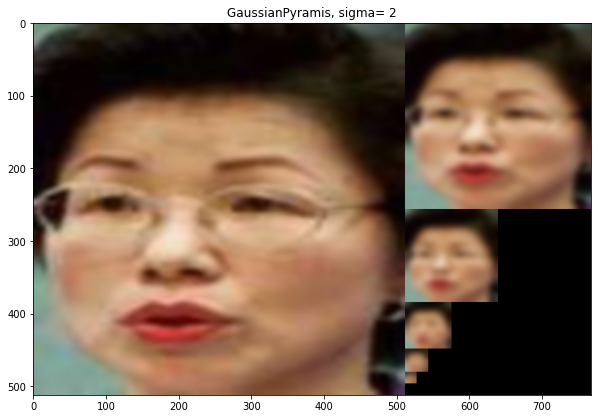

In [4]:
#=================
# Resize Function
#=================   
def _resize(image, downscale=2, step=2, minSize=(7, 7)):
    if(image.shape > minSize ):
        newSize = (image.shape[0]// downscale, image.shape[1]//downscale)
        newImage = cv2.resize(image, dsize=newSize, fx=step, fy=step) 
        return newImage
    else:
        return 0
#===========================
# Gaussian Pyramid Function
#===========================
def pyramid(image, sigma_0=1):
    '''
    Function to create a Gaussian pyramid from an image for given standard deviation sigma_0

    Parameters:
    -----------
    @param: image: nd-array.
             The original image.
    @param: sigma_0: float.
            standard deviation of the Gaussian distribution.

    returns:
    List of images with different scales, the pyramid
    '''
    # Resize All input images into a standard size
    image = cv2.resize(image,(512,512))

    # level 0
    if ceil(6*sigma_0)%2 ==0 : 
        Gimage = cv2.GaussianBlur(image, (ceil(6*sigma_0)+1, ceil(6*sigma_0)+1), sigmaX=sigma_0, sigmaY=sigma_0)
    else:
        Gimage = cv2.GaussianBlur(image, (ceil(6*sigma_0)+2, ceil(6*sigma_0)+2), sigmaX=sigma_0, sigmaY=sigma_0)
    # sigma_k
    sigma_k = 4*sigma_0
    # Pyramid as list
    GaussPyr = [Gimage]

    # Loop  of other levels of the pyramid
    for k in range(1,6):

        if ceil(6*sigma_k)%2 ==0 :
            smoothed = cv2.GaussianBlur(GaussPyr[k-1], (ceil(6*sigma_k)+1, ceil(6*sigma_k)+1), sigmaX=sigma_k, sigmaY=sigma_k)
        else:
            smoothed = cv2.GaussianBlur(GaussPyr[k-1], (ceil(6*sigma_k)+2, ceil(6*sigma_k)+2), sigmaX=sigma_k, sigmaY=sigma_k)

        # Downscaled Image
        resized = _resize(smoothed ,step=0.25*sigma_k)
        GaussPyr.append(resized)
    return GaussPyr
#--------------------------------------------------------------
# Read Image
#=============
img = cv2.imread('/content/test/face/0001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# sigma
sigma = 2

# Create a Gaussian pyramid
pyr1 = pyramid(img, sigma_0=sigma)

# Visualizse the Pyramid
container = np.zeros((512, 768, 3), dtype=int)
oldrows = 0
container[:512, :512, :] = pyr1[0]

for idx, im in enumerate(pyr1):
    if idx != 0 :
        nrows, ncols = pyr1[idx].shape[0], pyr1[idx].shape[1]
        container[oldrows:oldrows+nrows, 512:512+ncols,:] = pyr1[idx]
        oldrows += nrows
#====================
# Visualize Results
#====================
plt.figure(num="Pyramids", figsize=(10,10))
plt.imshow(container)
plt.title("GaussianPyramis, sigma= {}".format(sigma))
plt.show()

#### Pyramid Impulse Response

Impulse Response

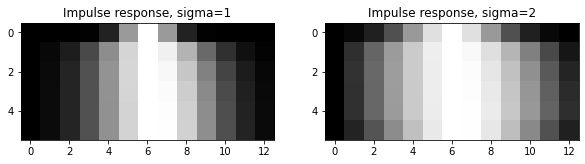

In [8]:
#====================
# Impulse Response
#====================
# Zeros 512x512 Black Image
delta = np.zeros((512, 512), dtype=np.float32)
# Dirac
delta[255,255] = 255

# sigmas
sigma1 = 1
sigma2 = sqrt(2)

# Pyramids
deltaPyramid1 = pyramid(delta, sigma_0=sigma1)
deltaPyramid2 = pyramid(delta, sigma_0=sigma2)

# Impulse Response for each level
ImpResp1 = np.zeros((len(deltaPyramid1), 13),dtype=float)
ImpResp2 = np.zeros((len(deltaPyramid2), 13),dtype=float)
# sigma = 1
for idx, level in enumerate(deltaPyramid1):
    # # 1
    # level = cv2.resize(level, (512, 512))# , interpolation=cv2.INTER_AREA
    # ImpResp1[idx,:] = exposure.rescale_intensity(level[255, 249:262], in_range='image', out_range=(0,255)).astype(np.uint8)

    # # 2
    centery = level.shape[0]//2
    centerx = level.shape[1]//2
    ImpResp1[idx,:] = exposure.rescale_intensity(level[centery, (centerx-7):(centerx+6)], out_range=(0,255), in_range='image').astype(np.uint8)
# sigma = sqrt(2)
for idx, level in enumerate(deltaPyramid2):
    # # 1
    # level = cv2.resize(level, (512, 512))# , interpolation=cv2.INTER_AREA
    # ImpResp1[idx,:] = exposure.rescale_intensity(level[255, 249:262], in_range='image', out_range=(0,255)).astype(np.uint8)

    # # 2
    centery = level.shape[0]//2
    centerx = level.shape[1]//2
    ImpResp2[idx,:] = exposure.rescale_intensity(level[centery, (centerx-7):(centerx+6)], out_range=(0,255), in_range='image').astype(np.uint8)

#====================
# Visualize Results
#====================
plt.figure(num="Pyramids", figsize=(10,10))
plt.subplot(121)
plt.imshow(ImpResp1, cmap='gray')
plt.title('Impulse response, sigma={}'.format(sigma1))

plt.subplot(122)
plt.imshow(ImpResp2, cmap='gray')
plt.title('Impulse response, sigma={}'.format(sigma2))
plt.show()

#### Comparision
The Pyramid is scale invariant for any $\sigma_0$, but smoothing and kernel size are related to the $\sigma_0$.

### Q2: MLP for Face Detection

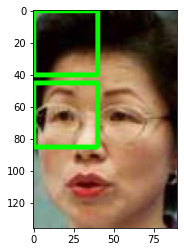

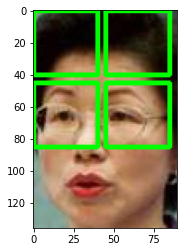

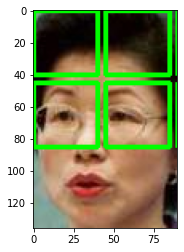

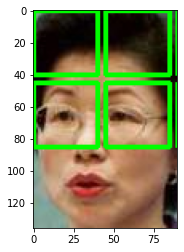

image size: (136, 90, 3)


In [7]:
image = cv2.imread("/content/test/face/0001.jpg") 
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sli_win = img 
(winW, winH) = (16, 16) # from 16*16 to 100*100
# loop over the image pyramid
# for resized in pyramid(image, sigma=1):
# 	# loop over the sliding window for each layer of the pyramid
# 	for sli_win in sliding_window_extractor(resized, stepSize=32, windowSize=(winW, winH)):
# 		# if the window does not meet our desired window size, ignore it
# 		if window.shape[0] != winH or window.shape[1] != winW:
# 			continue

def sliding_window_extractor(image, stepSize, windowSize):
 
  for row in range(0, image.shape[0], stepSize):
    for col in range(0, image.shape[1], stepSize):
          window = img[row:row + windowSize[0], col:col + windowSize[1], :]
          # Apply bestMLP to classify face from the background here
          # since I don't how to add bestMLP.h5 model here, I'll just draw the window


          cv2.rectangle(sli_win, (row, col), (row + windowSize[0], col + windowSize[1]), (0, 255, 0), 2)
          plt.imshow(np.array(sli_win).astype('uint8'))
    
          #Resize the window extracted to the input of bestMLP network
          window.resize() 
    plt.show()
    
sliding_window_extractor(img,45,(40,40))

# show all windows
# plt.show()
print('image size:',img.shape)

